## Frog tongue
Kleinteich and Gorb (Sci. Rep., 4, 5225, 2014) performed an interesting experiment with South American horned frogs. They held a plate connected to a force transducer, along with a bait fly, in front of them. They then measured the impact force and adhesive force of the frog's tongue when it struck the target.

Frog A is an adult and Frog B is a juvenile. The researchers measured the impact force of 20 strikes for each frog. In the next exercise, we will test the hypothesis that the two frogs have the same distribution of impact forces. But, remember, it is important to do EDA first! Let's make a bee swarm plot for the data. They are stored in a Pandas data frame, df, where column ID is the identity of the frog and column impact_force is the impact force in Newtons (N).

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv('frog_tongue.csv',comment='#')
df.head()

,date,ID,trial number,impact force (mN),impact time (ms),impact force / body weight,adhesive force (mN),time frog pulls on target (ms),adhesive force / body weight,adhesive impulse (N-s),total contact area (mm2),contact area without mucus (mm2),contact area with mucus / contact area without mucus,contact pressure (Pa),adhesive strength (Pa)
0,2013_02_26,I,3,1205,46,1.95,-785,884,1.27,-0.290,387,70,0.82,3117,-2030
1,2013_02_26,I,4,2527,44,4.08,-983,248,1.59,-0.181,101,94,0.07,24923,-9695
2,2013_03_01,I,1,1745,34,2.82,-850,211,1.37,-0.157,83,79,0.05,21020,-10239
3,2013_03_01,I,2,1556,41,2.51,-455,1025,0.74,-0.170,330,158,0.52,4718,-1381
4,2013_03_01,I,3,493,36,0.80,-974,499,1.57,-0.423,245,216,0.12,2012,-3975


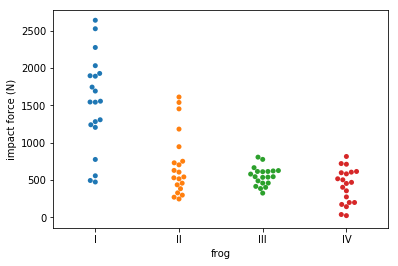

In [3]:
# Make bee swarm plot
_ = sns.swarmplot(x = 'ID', y ='impact force (mN)' ,data = df)

# Label axes
_ = plt.xlabel('frog')
_ = plt.ylabel('impact force (N)')

# Show the plot
plt.show()


### Permutation test on frog data (Case 1)

The average strike force of Frog A was 0.71 Newtons (N), and that of Frog B was 0.42 N for a difference of 0.29 N. It is possible the frogs strike with the same force and this observed difference was by chance. We will compute the probability of getting at least a 0.29 N difference in mean strike force under the hypothesis that the distributions of strike forces for the two frogs are identical. We will use a permutation test with a test statistic of the difference of means to test this hypothesis.

In [6]:
force_a = np.array(df['impact force (mN)'][df['ID']=='II'])/1000
force_b = np.array(df['impact force (mN)'][df['ID']=='IV'])/1000

In [7]:
forces_concat = np.concatenate([force_a, force_b])

#### Generating permutation replicates

In [8]:
def permutation_sample(data1, data2):
    """Generate a permutation sample from two data sets."""

    # Concatenate the data sets: data
    data = np.concatenate((data1, data2))

    # Permute the concatenated array: permuted_data
    permuted_data = np.random.permutation(data)

    # Split the permuted array into two: perm_sample_1, perm_sample_2
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]

    return perm_sample_1, perm_sample_2

In [9]:
def draw_perm_reps(data_1, data_2, func, size=1):
    """Generate multiple permutation replicates."""

    # Initialize array of replicates: perm_replicates
    perm_replicates = np.empty(size)

    for i in range(size):
        # Generate permutation sample
        perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)

        # Compute the test statistic
        perm_replicates[i] = func(perm_sample_1, perm_sample_2)

    return perm_replicates

In [10]:
def diff_of_means(data_1, data_2):
    """Difference in means of two arrays."""

    # The difference of means of data_1, data_2: diff
    diff = np.mean(data_1) - np.mean(data_2)

    return diff



In [11]:
# Compute difference of mean impact force from experiment: empirical_diff_means
empirical_diff_means = diff_of_means(force_a, force_b)

# Draw 10,000 permutation replicates: perm_replicates
perm_replicates = draw_perm_reps(force_a, force_b,
                                 diff_of_means, size=10000)

# Compute p-value: p
p = np.sum(perm_replicates >= empirical_diff_means) / len(perm_replicates)

# Print the result
print('p-value =', p)

p-value = 0.0042


The p-value tells you that there is about a 0.6% chance that you would get the difference of means observed in the experiment if frogs were exactly the same. A p-value below 0.01 is typically said to be "statistically significant," but: warning! warning! warning! You have computed a p-value; it is a number. I encourage you not to distill it to a yes-or-no phrase. p = 0.006 and p = 0.000000006 are both said to be "statistically significant," but they are definitely not the same!

### A one-sample bootstrap hypothesis test (Case 2)

Another juvenile frog was studied, Frog C, and you want to see if Frog B and Frog C have similar impact forces. Unfortunately, you do not have Frog C's impact forces available, but you know they have a mean of 0.55 N. Because you don't have the original data, you cannot do a permutation test, and you cannot assess the hypothesis that the forces from Frog B and Frog C come from the same distribution. You will therefore test another, less restrictive hypothesis: The mean strike force of Frog B is equal to that of Frog C.

To set up the bootstrap hypothesis test, you will take the mean as our test statistic. Remember, **your goal is to calculate the probability of getting a mean impact force less than or equal to what was observed for Frog B if the hypothesis that the true mean of Frog B's impact forces is equal to that of Frog C is true.** You first translate all of the data of Frog B such that the mean is 0.55 N. This involves adding the mean force of Frog C and subtracting the mean force of Frog B from each measurement of Frog B. This leaves other properties of Frog B's distribution, such as the variance, unchanged.

In [29]:
def bootstrap_replicate_1d(data, func):
    """Generate bootstrap replicate of 1D data."""
    bs_sample = np.random.choice(data, len(data))
    return func(bs_sample)

In [30]:
def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)

    return bs_replicates



In [31]:
# Make an array of translated impact forces: translated_force_b
translated_force_b = force_b - np.mean(force_b) + 0.55 

# Take bootstrap replicates of Frog B's translated impact forces: bs_replicates
bs_replicates = draw_bs_reps(translated_force_b, np.mean, 10000)

# Compute fraction of replicates that are less than the observed Frog B force: p
p = np.sum(bs_replicates <= np.mean(force_b)) / 10000

# Print the p-value
print('p = ', p)


p =  0.005


The low p-value suggests that the null hypothesis that Frog B and Frog C have the same mean impact force is false.

### A two-sample bootstrap hypothesis test for difference of means (Case 3)

We now want to test the hypothesis that Frog A and Frog B have the same mean impact force, but not necessarily the same distribution, which is also impossible with a permutation test.

To do the two-sample bootstrap test, we shift both arrays to have the same mean, since we are simulating the hypothesis that their means are, in fact, equal. We then draw bootstrap samples out of the shifted arrays and compute the difference in means. This constitutes a bootstrap replicate, and we generate many of them. The p-value is the fraction of replicates with a difference in means greater than or equal to what was observed.


In [44]:
# Compute mean of all forces: mean_force
mean_force = np.mean(forces_concat)

# Generate shifted arrays
force_a_shifted = force_a - np.mean(force_a) + mean_force
force_b_shifted = force_b - np.mean(force_b) + mean_force 

# Compute 10,000 bootstrap replicates from shifted arrays
bs_replicates_a = draw_bs_reps(force_a_shifted, np.mean, 10000)
bs_replicates_b = draw_bs_reps(force_b_shifted, np.mean, 10000)

# Get replicates of difference of means: bs_replicates
bs_replicates = bs_replicates_a - bs_replicates_b


# Compute and print p-value: p
p = np.sum(bs_replicates >= empirical_diff_means) / 10000
print('p-value =', p)



p-value = 0.0041


You got a similar result as when you did the permutation test. Nonetheless, remember that it is important to carefully think about what question you want to ask. **Are you only interested in the mean impact force (case 3), or in the distribution of impact forces? (case 1)** 